# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. This code is already included in 'tensorflow_vgg' directory, sdo you don't have to clone it.

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. **You'll need to clone the repo into the folder containing this notebook.** Then download the parameter file using the next cell.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [3]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

Flowers Dataset: 229MB [01:00, 3.76MB/s]                              


## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $224 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`). To build the network, we use

```
with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)
```

This creates the `vgg` object, then builds the graph with `vgg.build(input_)`. Then to get the values from the layer,

```
feed_dict = {input_: images}
codes = sess.run(vgg.relu6, feed_dict=feed_dict)
```

In [3]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [6]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
# collect all listings that are actually directories (isdir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

In [16]:
import importlib
importlib.reload(vgg16)

<module 'tensorflow_vgg.vgg16' from '/Users/blainejohnson/Documents/working/udacity-deep-learning/deep-learning/transfer-learning/tensorflow_vgg/vgg16.py'>

Below I'm running images through the VGG network in batches.

> **Exercise:** Below, build the VGG network. Also get the codes from the first fully connected layer (make sure you get the ReLUd values).

In [17]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                # TODO: Get the values from the relu6 layer of the VGG network
                codes_batch = sess.run(vgg.relu6, feed_dict={input_: images})
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/Users/blainejohnson/Documents/working/udacity-deep-learning/deep-learning/transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started


build model finished: 4s
Starting roses images
10 images processed
20 images processed
30 images processed
40 images processed
50 images processed
60 images processed
70 images processed
80 images processed
90 images processed
100 images processed
110 images processed
120 images processed
130 images processed
140 images processed
150 images processed
160 images processed
170 images processed
180 images processed
190 images processed
200 images processed
210 images processed
220 images processed
230 images processed
240 images processed
250 images processed
260 images processed
270 images processed
280 images processed
290 images processed
300 images processed
310 images processed
320 images processed
330 images processed
340 images processed
350 images processed
360 images processed
370 images processed
380 images processed
390 imag

690 images processed
700 images processed
710 images processed
720 images processed
730 images processed
740 images processed
750 images processed
760 images processed
770 images processed
780 images processed
790 images processed
799 images processed


In [18]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

In [19]:
print(codes)

[[ 9.872929    0.          0.         ...  0.          0.
   0.        ]
 [ 0.7314124   2.2007642   0.         ...  0.          3.7424264
   2.9010477 ]
 [ 0.         13.204748    9.950476   ...  0.77103555  1.5149992
   3.2841783 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 6.06803     1.3286608   0.993098   ...  8.827642    0.
   9.579642  ]
 [15.098195    1.526055    0.         ...  0.          0.
   0.        ]]


In [20]:
len(labels)

3670

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [4]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [22]:
print(classes)

['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']


In [7]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(classes)
# Your one-hot encoded labels array here
labels_vecs = lb.transform(labels)

Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
splitter = ss.split(codes, labels_vecs)

train_index, test_index = next(splitter)

train_x, train_y = codes[train_index], labels_vecs[train_index]
val_test_x, val_test_y = codes[test_index], labels_vecs[test_index]

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
splitter = ss.split(val_test_x, val_test_y)

val_index, test_index = next(splitter)
val_x, val_y = val_test_x[val_index], val_test_y[val_index]
test_x, test_y = val_test_x[test_index], val_test_y[test_index]

In [9]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


If you did it right, you should see these sizes for the training sets:

```
Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)
```

### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [16]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.float32, shape=[None, labels_vecs.shape[1]])

# TODO: Classifier layers and operations
hidden = tf.layers.dense(inputs_, 2500, activation=tf.nn.relu)

logits = tf.layers.dense(hidden, 5, activation=None)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(loss)

optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [11]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help. Use the `get_batches` function I wrote before to get your batches like `for x, y in get_batches(train_x, train_y)`. Or write your own!

In [18]:
epochs = 100
saver = tf.train.Saver()


with tf.Session() as sess:    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        batch_i = 0
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x, labels_: y}
            c, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch {}/{}".format(e, epochs),
                  "Iteration {}".format(batch_i),
                  "Cost {}".format(c))

            batch_i += 1

            if batch_i % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration {}".format(batch_i),
                      "Acc {:.4f}".format(acc))
            
            
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch 0/100 Iteration 0 Cost 1.5145235061645508
Epoch 0/100 Iteration 1 Cost 18.24150848388672
Epoch 0/100 Iteration 2 Cost 14.52227783203125
Epoch 0/100 Iteration 3 Cost 12.03187370300293
Epoch 0/100 Iteration 4 Cost 9.139806747436523
Epoch: 0/100 Iteration 5 Acc 0.5232
Epoch 0/100 Iteration 5 Cost 6.5453643798828125
Epoch 0/100 Iteration 6 Cost 4.688840389251709
Epoch 0/100 Iteration 7 Cost 2.043617010116577
Epoch 0/100 Iteration 8 Cost 2.7123398780822754
Epoch 0/100 Iteration 9 Cost 3.730602264404297
Epoch: 0/100 Iteration 10 Acc 0.7384
Epoch 1/100 Iteration 0 Cost 2.9446191787719727
Epoch 1/100 Iteration 1 Cost 1.495398998260498
Epoch 1/100 Iteration 2 Cost 1.3779668807983398
Epoch 1/100 Iteration 3 Cost 1.2286463975906372
Epoch 1/100 Iteration 4 Cost 1.2204707860946655
Epoch: 1/100 Iteration 5 Acc 0.7929
Epoch 1/100 Iteration 5 Cost 1.2750450372695923
Epoch 1/100 Iteration 6 Cost 1.3072272539138794
Epoch 1/100 Iteration 7 Cost 1.1384297609329224
Epoch 1/100 Iteration 8 Cost 1.1611

Epoch 14/100 Iteration 5 Cost 0.003606304759159684
Epoch 14/100 Iteration 6 Cost 0.004486583638936281
Epoch 14/100 Iteration 7 Cost 0.006153994705528021
Epoch 14/100 Iteration 8 Cost 0.004286950454115868
Epoch 14/100 Iteration 9 Cost 0.004716985393315554
Epoch: 14/100 Iteration 10 Acc 0.9046
Epoch 15/100 Iteration 0 Cost 0.004206718411296606
Epoch 15/100 Iteration 1 Cost 0.003586050122976303
Epoch 15/100 Iteration 2 Cost 0.0029996233060956
Epoch 15/100 Iteration 3 Cost 0.003559719305485487
Epoch 15/100 Iteration 4 Cost 0.003951218910515308
Epoch: 15/100 Iteration 5 Acc 0.9046
Epoch 15/100 Iteration 5 Cost 0.0032291982788592577
Epoch 15/100 Iteration 6 Cost 0.0038337402511388063
Epoch 15/100 Iteration 7 Cost 0.005106098018586636
Epoch 15/100 Iteration 8 Cost 0.0037964514922350645
Epoch 15/100 Iteration 9 Cost 0.0041725048795342445
Epoch: 15/100 Iteration 10 Acc 0.9074
Epoch 16/100 Iteration 0 Cost 0.004183424636721611
Epoch 16/100 Iteration 1 Cost 0.003004056867212057
Epoch 16/100 Itera

Epoch 28/100 Iteration 5 Cost 0.0011928078019991517
Epoch 28/100 Iteration 6 Cost 0.0012893177336081862
Epoch 28/100 Iteration 7 Cost 0.0015290317824110389
Epoch 28/100 Iteration 8 Cost 0.0013865018263459206
Epoch 28/100 Iteration 9 Cost 0.001481610699556768
Epoch: 28/100 Iteration 10 Acc 0.9128
Epoch 29/100 Iteration 0 Cost 0.0023490218445658684
Epoch 29/100 Iteration 1 Cost 0.0018437966937199235
Epoch 29/100 Iteration 2 Cost 0.0009896827396005392
Epoch 29/100 Iteration 3 Cost 0.0011696700239554048
Epoch 29/100 Iteration 4 Cost 0.0012497169664129615
Epoch: 29/100 Iteration 5 Acc 0.9101
Epoch 29/100 Iteration 5 Cost 0.0011296318843960762
Epoch 29/100 Iteration 6 Cost 0.0012122526532039046
Epoch 29/100 Iteration 7 Cost 0.0014330105623230338
Epoch 29/100 Iteration 8 Cost 0.0013013246934860945
Epoch 29/100 Iteration 9 Cost 0.0013992657186463475
Epoch: 29/100 Iteration 10 Acc 0.9128
Epoch 30/100 Iteration 0 Cost 0.0021193132270127535
Epoch 30/100 Iteration 1 Cost 0.0019470234401524067
Epoc

Epoch 42/100 Iteration 5 Cost 0.0006258520879782736
Epoch 42/100 Iteration 6 Cost 0.0006683688843622804
Epoch 42/100 Iteration 7 Cost 0.0007689123740419745
Epoch 42/100 Iteration 8 Cost 0.0007986212149262428
Epoch 42/100 Iteration 9 Cost 0.0007951293955557048
Epoch: 42/100 Iteration 10 Acc 0.9128
Epoch 43/100 Iteration 0 Cost 0.004339050967246294
Epoch 43/100 Iteration 1 Cost 0.0006335421930998564
Epoch 43/100 Iteration 2 Cost 0.0005027959123253822
Epoch 43/100 Iteration 3 Cost 0.0006045920308679342
Epoch 43/100 Iteration 4 Cost 0.000638902245555073
Epoch: 43/100 Iteration 5 Acc 0.9128
Epoch 43/100 Iteration 5 Cost 0.0005976108368486166
Epoch 43/100 Iteration 6 Cost 0.0006516368594020605
Epoch 43/100 Iteration 7 Cost 0.0007629392785020173
Epoch 43/100 Iteration 8 Cost 0.0006759102689102292
Epoch 43/100 Iteration 9 Cost 0.0007876874879002571
Epoch: 43/100 Iteration 10 Acc 0.9128
Epoch 44/100 Iteration 0 Cost 0.0007697059772908688
Epoch 44/100 Iteration 1 Cost 0.0037043490447103977
Epoch

Epoch 56/100 Iteration 4 Cost 0.00037529857945628464
Epoch: 56/100 Iteration 5 Acc 0.9128
Epoch 56/100 Iteration 5 Cost 0.0003635540488176048
Epoch 56/100 Iteration 6 Cost 0.00039090460631996393
Epoch 56/100 Iteration 7 Cost 0.00043951449333690107
Epoch 56/100 Iteration 8 Cost 0.0004709205240942538
Epoch 56/100 Iteration 9 Cost 0.0004734562535304576
Epoch: 56/100 Iteration 10 Acc 0.9128
Epoch 57/100 Iteration 0 Cost 0.004886910784989595
Epoch 57/100 Iteration 1 Cost 0.00039076924440450966
Epoch 57/100 Iteration 2 Cost 0.0003134298312943429
Epoch 57/100 Iteration 3 Cost 0.0003668375429697335
Epoch 57/100 Iteration 4 Cost 0.000364580744644627
Epoch: 57/100 Iteration 5 Acc 0.9101
Epoch 57/100 Iteration 5 Cost 0.00035121847759000957
Epoch 57/100 Iteration 6 Cost 0.00037481074105016887
Epoch 57/100 Iteration 7 Cost 0.0004309082869440317
Epoch 57/100 Iteration 8 Cost 0.00040461053140461445
Epoch 57/100 Iteration 9 Cost 0.0004676556563936174
Epoch: 57/100 Iteration 10 Acc 0.9128
Epoch 58/100 

Epoch 70/100 Iteration 2 Cost 0.00022753930534236133
Epoch 70/100 Iteration 3 Cost 0.00025006214855238795
Epoch 70/100 Iteration 4 Cost 0.0002462285337969661
Epoch: 70/100 Iteration 5 Acc 0.9128
Epoch 70/100 Iteration 5 Cost 0.00024143353221006691
Epoch 70/100 Iteration 6 Cost 0.0002617770223878324
Epoch 70/100 Iteration 7 Cost 0.00028949297848157585
Epoch 70/100 Iteration 8 Cost 0.00031159105128608644
Epoch 70/100 Iteration 9 Cost 0.000315281271468848
Epoch: 70/100 Iteration 10 Acc 0.9128
Epoch 71/100 Iteration 0 Cost 0.00520545057952404
Epoch 71/100 Iteration 1 Cost 0.0002792750601656735
Epoch 71/100 Iteration 2 Cost 0.00021290185395628214
Epoch 71/100 Iteration 3 Cost 0.0002486597222741693
Epoch 71/100 Iteration 4 Cost 0.0002401558158453554
Epoch: 71/100 Iteration 5 Acc 0.9101
Epoch 71/100 Iteration 5 Cost 0.00023565100855194032
Epoch 71/100 Iteration 6 Cost 0.00025001305039040744
Epoch 71/100 Iteration 7 Cost 0.0002849239972420037
Epoch 71/100 Iteration 8 Cost 0.0002728975960053503

Epoch 84/100 Iteration 0 Cost 0.00026095984503626823
Epoch 84/100 Iteration 1 Cost 0.00487494794651866
Epoch 84/100 Iteration 2 Cost 0.00016954384045675397
Epoch 84/100 Iteration 3 Cost 0.00018293596804141998
Epoch 84/100 Iteration 4 Cost 0.00017948706226889044
Epoch: 84/100 Iteration 5 Acc 0.9155
Epoch 84/100 Iteration 5 Cost 0.0001842113706516102
Epoch 84/100 Iteration 6 Cost 0.00019445134967099875
Epoch 84/100 Iteration 7 Cost 0.00021060941799078137
Epoch 84/100 Iteration 8 Cost 0.00022901510237716138
Epoch 84/100 Iteration 9 Cost 0.00024265573301818222
Epoch: 84/100 Iteration 10 Acc 0.9128
Epoch 85/100 Iteration 0 Cost 0.005537241231650114
Epoch 85/100 Iteration 1 Cost 0.0002170907100662589
Epoch 85/100 Iteration 2 Cost 0.00016004241479095072
Epoch 85/100 Iteration 3 Cost 0.00018304830882698298
Epoch 85/100 Iteration 4 Cost 0.00017625236068852246
Epoch: 85/100 Iteration 5 Acc 0.9128
Epoch 85/100 Iteration 5 Cost 0.0001828894455684349
Epoch 85/100 Iteration 6 Cost 0.0001835877192206

Epoch 97/100 Iteration 9 Cost 0.0001734942925395444
Epoch: 97/100 Iteration 10 Acc 0.9155
Epoch 98/100 Iteration 0 Cost 0.0002032455668086186
Epoch 98/100 Iteration 1 Cost 0.005015584174543619
Epoch 98/100 Iteration 2 Cost 0.00012924162729177624
Epoch 98/100 Iteration 3 Cost 0.00013553901226259768
Epoch 98/100 Iteration 4 Cost 0.00013312726514413953
Epoch: 98/100 Iteration 5 Acc 0.9183
Epoch 98/100 Iteration 5 Cost 0.000134575879201293
Epoch 98/100 Iteration 6 Cost 0.00014129058399703354
Epoch 98/100 Iteration 7 Cost 0.00015577729209326208
Epoch 98/100 Iteration 8 Cost 0.0001710742653813213
Epoch 98/100 Iteration 9 Cost 0.0001726708869682625
Epoch: 98/100 Iteration 10 Acc 0.9155
Epoch 99/100 Iteration 0 Cost 0.005769861862063408
Epoch 99/100 Iteration 1 Cost 0.0001687979674898088
Epoch 99/100 Iteration 2 Cost 0.00012037793931085616
Epoch 99/100 Iteration 3 Cost 0.00013679068069905043
Epoch 99/100 Iteration 4 Cost 0.0001305893820244819
Epoch: 99/100 Iteration 5 Acc 0.9155
Epoch 99/100 I

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [19]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.8937


In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread


Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


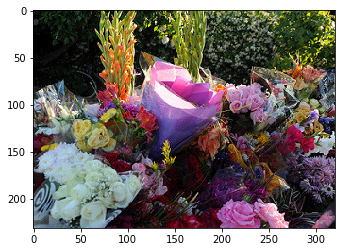

In [21]:
test_img_path = 'flower_photos/roses/10894627425_ec76bbc757_n.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [22]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

/Users/blainejohnson/Documents/working/udacity-deep-learning/deep-learning/transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started


build model finished: 4s


In [23]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


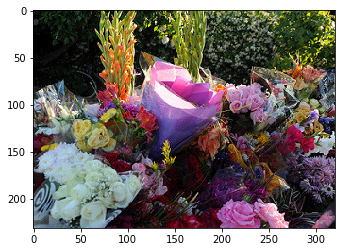

In [24]:
plt.imshow(test_img)

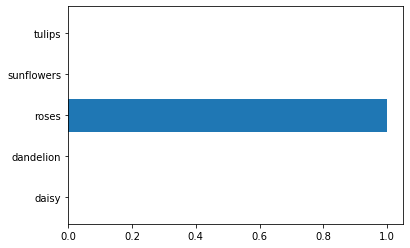

In [25]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)